In [1]:
import autotime
%load_ext autotime

%matplotlib inline

In [412]:
from PIL import Image
from pytesseract import image_to_string

import numpy as np
from unidecode import unidecode

import os
import sys

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from skimage import measure

import enchant

from itertools import permutations, combinations, chain

import time

import copy

time: 6.92 ms


In [468]:
# Grab screenshot from adb
output_code = os.system("adb exec-out screencap -p > /MAKE/THIS/YOUR/DESIRED/LOCAL/PATH/screen.png") # This location is used in the next block


time: 1.85 s


[['E', (1082, 540)], ['B', (1202, 331)], ['D', (1202, 748)], ['R', (1443, 330)], ['I', (1442, 747)], ['I', (1562, 539)]]
NUM WORDS: 21


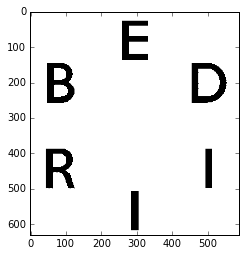

time: 1.87 s


In [469]:
# Open the screenshot
img = Image.open('./screen.png')
# Crop where we have (column, row, width, height) of crop
# new_img = img
# new_img = img.crop((475, 1000, img.size[0]-475, 1150)) #img.size[0] should be 1080

# Crop tuple:(left, upper, right, lower)
crop_tuple = (245, 1000, 835, 1630)
new_img = img.crop(crop_tuple) #img.size[0] should be 1080

# Convert to black and white
gray = new_img.convert('L')
bw = gray.point(lambda x: 255 if x>0 else 0, '1')
imshow(bw)

# imshow(np.asarray(new_img))
# width = 100
# new_img = np.pad(np.asarray(new_img), ((width, width), (width, width), (0, 0)), 'constant', constant_values=(0, 0))
# imshow(bw)

# Get the connected components (letters)
blobs = measure.label(np.asarray(bw))

# Snag all admissable letters (since we have some letters that have holes in them like 'A')
admissable_bboxes = []
for blob in measure.regionprops(blobs):
    minr, minc, maxr, maxc = blob.bbox
    new_bbox = np.array([minr, maxr, minc, maxc])
    do_store = True
    for bbox in admissable_bboxes:
        if minr >= bbox[0] and maxr <= bbox[1] and minc >= bbox[2] and maxc <= bbox[3]:
            do_store = False
            break
    if do_store:
        admissable_bboxes.append(new_bbox)

#Get the letters of the components
letters = []
# letters_loc = {}
for blob in measure.regionprops(blobs):
    minr, minc, maxr, maxc = blob.bbox
    if str(np.array([minr, maxr, minc, maxc])) in [str(x) for x in admissable_bboxes]:
        shape = (maxr-minr+1, maxc-minc+75)
        loc = (int((maxr+minr)/2) + crop_tuple[1], int((maxc+minc)/2) + crop_tuple[0]) # spot of the letter in the original image
        tmp_letter = np.asarray(bw)[minr:maxr, minc:maxc].astype('uint8') + 255
        vert_pad = int((shape[0]-tmp_letter.shape[0])/2)
        horz_pad = int((shape[1]-tmp_letter.shape[1])/2)
        tmp_letter = np.pad(tmp_letter, ((vert_pad, vert_pad), (horz_pad, horz_pad)), 'constant', constant_values=(0, 0))
        tmp_letter_img = Image.fromarray(tmp_letter)
        # Try to use OCR to convert it
        letter = str(image_to_string(tmp_letter_img, lang='eng', config='-psm 10')).upper()
        letters.append([letter, loc])
#         letters_loc[letter] = loc
# letters = np.array(letters)
print letters
# print letters_loc
#     imshow(tmp_letter_img)

# Find all possible words
d = enchant.Dict("en_US")
words = []
only_letters = [x[0] for x in letters]
for test_letters in chain.from_iterable(combinations(only_letters,n) for n in range(3,len(only_letters)+1)):
    for i in permutations(''.join(test_letters)):
        if d.check(''.join(i).lower()):
#             print ''.join(i)
            words.append(i)
words = np.unique(np.array(words))
print 'NUM WORDS:', words.shape[0]

In [470]:
for word in words:
    letters_copy = copy.deepcopy(letters)
    print ''.join(word), '---',
    # Drag out the word
    for index, curr_letter in enumerate(word[:-1]):
#         curr_loc = letters_loc[letter]
#         next_loc = letters_loc[word[index + 1]]

        # List of what letters remain
        only_letters = [x[0] for x in letters_copy]
        
        # Get the current letter index and thus location
        curr_letter_index = only_letters.index(curr_letter)
        curr_loc = letters_copy[curr_letter_index][1]
        
        # Remove the current letter just in case it pops up again        
        letters_copy.pop(curr_letter_index)
        
        # Reset the letters that remain
        only_letters = [x[0] for x in letters_copy]
        
        # Get the next letter index and thus location
        next_letter_index = only_letters.index(word[index + 1])
        next_loc = letters_copy[next_letter_index][1]
                
        # Do command stuffs
        command = 'adb shell "input touchscreen swipe {0} {1} {2} {3} & input command touchscreen swipe {0} {1} {2} {3}"'.format(curr_loc[1], curr_loc[0], next_loc[1], next_loc[0])
        time.sleep(0.6)
        os.system(command)
    # End the tapping
    time.sleep(0.3)
    command = 'adb shell input touchscreen swipe {0} {1} {2} {3}'.format(next_loc[1], next_loc[0], next_loc[1], next_loc[0])
    os.system(command)
    time.sleep(0.1)
    

BED --- BID --- BIDE --- BIDER --- BIER --- BIRD --- BIRDIE --- BRED --- BRIDE --- DEB --- DIE --- DIRE ---

KeyboardInterrupt: 

time: 1min 12s
